# Итоговое задание по Проекту 4. Банковский скоринг
***
### Импорт библиотек

In [1]:
import pandas as pd
from pandas import Series
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate# ???

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import os

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
RANDOM_SEED = 42
CURRENT_DATE = pd.to_datetime('13/10/2020')

In [5]:
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(2))
print('Размерность тестового датасета: ', test.shape)
display(test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [7]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

Получим информацию о датасете

In [13]:
df.info()
df.columns
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

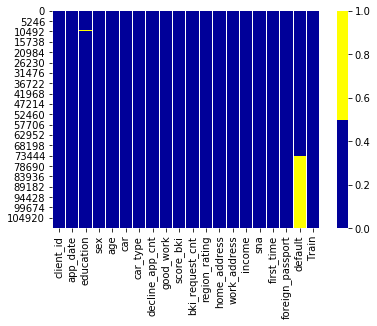

In [18]:
cols = df.columns 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Итого после предварительнго анализа можно выделить следующие моменты:
- в тренировочной выборке 73799 клиентов;
- в тестовой - 36349;

Общее количество данных 110148 клиентах.  
Всего 20 переменных:
- 1 - временной ряд;
- 6 бинарных;
- 7 категориальных;
- 8 числовых.

Всего 478 пропусков и все пропуски в переменной education.  
Пропуски в переменной default мы не учитываем, поскольку это целевая переменная и именно эти пропуски мы должны предсказать   
client_id - уникальный числовой признак, который не несет полезностей.  
В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

Для наглядности посмотрим на признак с пропусками на графике

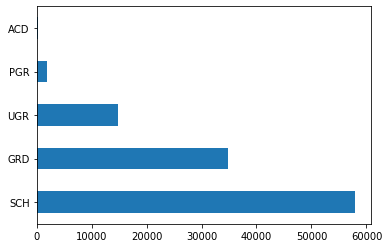

In [15]:
df['education'].value_counts().plot.barh()

### Детальный анализ по переменным

***

Для начала распределим все признаки по категориям

In [39]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date', 'education', 'home_address', 'work_address', 'sna']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

Начнем с числовых переменных

### 1. AGE  
#### Возраст

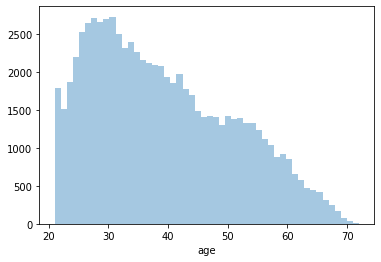

In [34]:
plt.figure()
sns.distplot(df['age'][df['Train']==1].dropna(), kde = False, rug=False)

Логарифмируем признак и посмотрим на его график

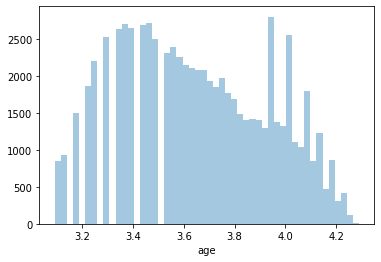

In [35]:
sns.distplot(np.log(df['age'] + 1)[df['Train']==1].dropna(), kde = False, rug=False)

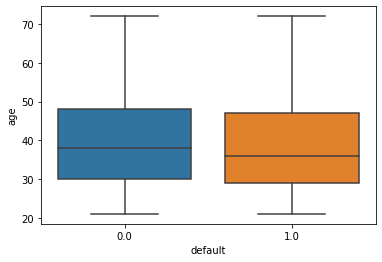

In [36]:
sns.boxplot(x=df.default, y=df.age)

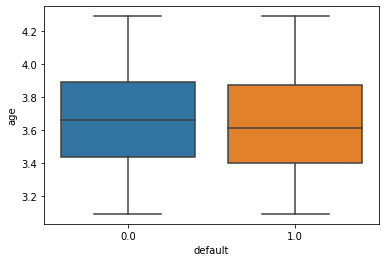

In [37]:
sns.boxplot(x=df.default, y=np.log(df['age'] + 1))

### AGE

Распределение логнормальное , выбросов нет.  
Признак логарифмировали для повышения точности модели машинного обучения

### 2.decline_app_cnt  
#### Количество отказанных прошлых заявок

In [50]:
df['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

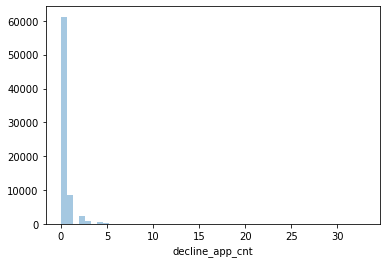

In [43]:
plt.figure()
sns.distplot(df['decline_app_cnt'][df['Train']==1].dropna(), kde = False, rug=False)

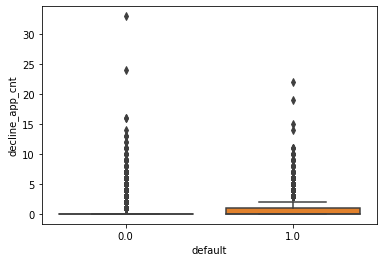

In [44]:
sns.boxplot(x=df.default, y=df.decline_app_cnt)

In [73]:
(df.loc[df['Train']==1]['decline_app_cnt']).quantile(0.25)

0.0

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


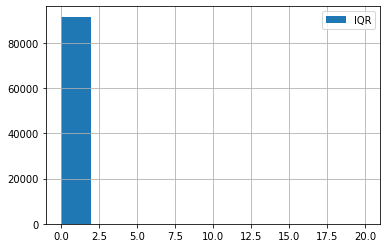

In [75]:
dft = (df.loc[df['Train']==1]['decline_app_cnt'])
median = dft.median()
perc25 = dft.quantile(0.25)
perc75 = dft.quantile(0.75)
IQR = perc75 - perc25
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
df['decline_app_cnt'].loc[df['decline_app_cnt'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins = 10, range = (0, 20), 
                                                                                             label = 'IQR')
plt.legend();

In [64]:
df.loc[(df['decline_app_cnt']>perc75 + 1.5*IQR),'decline_app_cnt'].value_counts().sum()

18677

Логарифмируем признак и посмотрим на его график

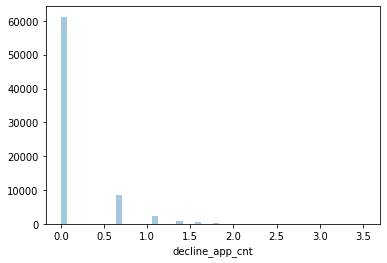

In [41]:
sns.distplot(np.log(df['decline_app_cnt'] + 1)[df['Train']==1].dropna(), kde = False, rug=False)

In [ ]:
df.loc[(df['decline_app_cnt']>perc75 + 1.5*IQR ),'decline_app_cnt'].value_counts()

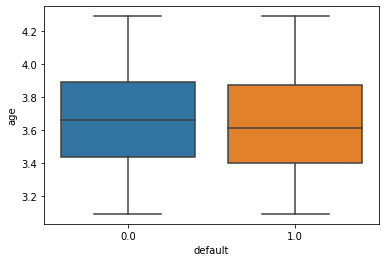

In [47]:
sns.boxplot(x=df.default, y=np.log(df['age'] + 1))

### decline_app_cnt

Распределение логнормальное , выбросов много.  
Признак логарифмировали 

Заполним пропуски значением, которое встречается чаще всего

In [ ]:
# fill NaN with the most frequent value


c_1 = collections.Counter(train['education'])
c_2 = collections.Counter(test['education'])

train['education'].fillna(c_1.most_common()[0][0], inplace=True)
test['education'].fillna(c_2.most_common()[0][0], inplace=True)

Проверим успешность заполнения

In [ ]:
train.isnull().sum(), test.isnull().sum()

Взглянем поближе на признак app_date

In [ ]:
train.app_date.head(5), test.app_date.head(5)

Сконветируем формат даты к удобному для работы

In [ ]:
# convert to datetime

train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(train.app_date)
print(train.app_date.head(2))
print(test.app_date.head(2))

In [ ]:
train.head(2)

На основе признака app_date создадим новые признаки

In [ ]:
current_date = pd.to_datetime('28JUL2020')

# Количество дней, прошедших со дня подачи заявки

train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

# Месяц подачи заявки

train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [ ]:
train.head(2)

In [ ]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date_month', 'education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

## Визуализация

In [ ]:
sns.countplot(train['default'])

In [ ]:
train['default'].value_counts()

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

Прологарифмируем переменные, которые вызывают вопросы в распределении

In [ ]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days_passed']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

In [ ]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(test[i][test[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

Построим матрицу корреляций

In [ ]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Высокой корреляции между признаками не наблюдается

Проанализируем боксплоты для численных переменных

In [ ]:
num_cols

In [ ]:
sns.boxplot(x=train.default, y=train.age)

Недефолтные клиенты в среднем старше дефолтных

In [ ]:
sns.boxplot(x=train.default, y=train.days_passed)

Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные. Это может быть связано со множеством факторов, вплоть до эффективности работы системы скоринга в банке в разные моменты времени. Но разница не настолько значительная, чтобы делать какие либо выводы.

In [ ]:
sns.boxplot(x=train.default, y=train.decline_app_cnt)

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных

In [ ]:
sns.boxplot(x=train.default, y=train.score_bki)

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850)

In [ ]:
sns.boxplot(x=train.default, y=train.region_rating)

Среднее значение в данном случае больше у недефолтных клиентов, в то время как медианы равны

In [ ]:
sns.boxplot(x=train.default, y=train.income)

Доход недефолтных клиентов выше, чем доход дефолтных

## Преобразование бинарных и категориальных переменных

Преобразуем бинарные переменные при помощи класса LabelEncoder

In [ ]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

    
# убедимся в преобразовании    
display(train.head())
display(test.head())

Преобразуем категориальные переменные при помощи OneHotEncoder

In [ ]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

In [ ]:
education_dummy = pd.get_dummies(train['education'])
education_dummy.head()

## Значимость непрерывных переменных

In [ ]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

## Значимость бинарных и категориальных переменных

In [ ]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(train[bin_cols], train['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

In [ ]:
# Значимость категориальных признаков

new_cat_cols = ['app_date_month', 'home_address', 'work_address', 'sna', 'first_time']

imp_cat = pd.Series(mutual_info_classif(pd.concat([train[new_cat_cols], education_dummy], axis=1),
                                        train['default'], discrete_features =True),
                    index = pd.concat([train[new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. А также мы можем увидеть значимость различных степеней образования на наш результат и наибольший вклад приносит признак GRD (graduate).

## Подготовка данных к машинному обучению

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [ ]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [ ]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

## Регуляризация

In [ ]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Обучим модель

In [ ]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X_train, y_train)

In [ ]:
probs = lgr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Обучим модель на всем датасете

In [ ]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [ ]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
#my_submission.to_csv('submission.csv', index=False)

my_submission